## Introduction

Often times it makes very difficult for a patient or a sufferer to choose the best hospital for his/her problem. They basically end up surfing online and what not. In order to reduce this, we can develop a user interface application where the patient can search for his/her problem and based on the user's location it should be able to segregate all the hospitals with a specific category and a breif summary or information about each cluster in order to help patient go with his/her valid decision.

By leveraging Foursquare API, we can easily get all the hospital locations and by keeping the patient's location center, we can show all the hospitals on a map.

The below is the procedure.

### Importing the required packages

In [1]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline

style.use('fivethirtyeight')

from sklearn.cluster import KMeans

import folium

### Foursquare Credentials

No matter what the `LIMIT` we take we only get `50` Hospitals along with the categories. We will need to parse it using `requests` library.

In [2]:
CLIENT_ID = 'ETQ33G4L2CFULPMCLWFBWOWCNCH0Y4HCYZCPC03HA1NDR3BW' # your Foursquare ID
CLIENT_SECRET = 'XYBA3LKD5MAO34WXR5BUNHHKFDOCU3KYAWDPKOD1BCVYHCN2' # your Foursquare Secret
VERSION = '20180628' # Foursquare API version
CATEGORY_ID = '4bf58dd8d48988d104941735'
LIMIT = 50
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ETQ33G4L2CFULPMCLWFBWOWCNCH0Y4HCYZCPC03HA1NDR3BW
CLIENT_SECRET:XYBA3LKD5MAO34WXR5BUNHHKFDOCU3KYAWDPKOD1BCVYHCN2


### Grabbing the hospitals according the patient's LAT & LON

In [3]:
def getAllHospitals(PLACE_LAT, PLACE_LON):
    data = [['Name', 'Latitude', 'Longitude', 'Address', 'City', 'State', 'Category']]
    url = 'https://api.foursquare.com/v2/venues/search?ll={},{}&categoryId={}&client_id={}&client_secret={}&limit={}&v={}'.format(
        PLACE_LAT,
        PLACE_LON,
        CATEGORY_ID,
        CLIENT_ID,
        CLIENT_SECRET,
        LIMIT,
        VERSION
    )
#     print(url)
    result = requests.get(url).json()['response']['venues']
    for res in range(len(result)):
        name = result[res]['name']
        location = result[res]['location']
        category = result[res]['categories'][0]['shortName']
        if len(location) > 11:
            latitude = result[res]['location']['lat']
            longitude = result[res]['location']['lng']
            address = result[res]['location']['address']
            city = result[res]['location']['city']
            state = result[res]['location']['state']
            data.append([
                name,
                latitude,
                longitude,
                address,
                city,
                state,
                category])
        else:
            latitude = result[res]['location']['lat']
            longitude = result[res]['location']['lng']
            city = 'Bangalore'
            state = 'Karnātaka'
            data.append([name,
                         latitude,
                         longitude,
                         np.nan,
                         city,
                         state,
                         category])
    return data

Since we are taking the hospitals as per patient's location, we will assign city as `Bangalore` and state as `Karnataka`. Above is the function that summarizes the following extracting the data.

### Bangalore Location Coordinates
<img src='example_image.png'>

In [4]:
LAT = 12.9716
LON= 77.5946

In [5]:
data = getAllHospitals(LAT, LON)

The data that are obtained is not the complete `Hospital` data of a cerain region. But as of now we just got 50 data values.

The `data` are in the `list` format. We have to convert it into `pandas` `DataFrame()` seperating the `headers`.

In [6]:
df = pd.DataFrame(data[1:], columns=data[0])
df.head()

,Name,Latitude,Longitude,Address,City,State,Category
0,Sagar Hospital,12.928226,77.599922,NaN,Bangalore,Karnātaka,Hospital
1,Fortis International Care,12.894674,77.599067,"154/9, Opposite IIM B",Bangalore,Karnātaka,Hospital
2,Manipal Hospital,12.959238,77.649208,#98,Bangalore,Karnātaka,Hospital
3,Columbia Asia Hospital,13.050844,77.593750,"Kirloskar Business Park, Bellary Rd",Bangalore,Karnātaka,Hospital
4,Apollo Hospital,12.896250,77.598653,NaN,Bangalore,Karnātaka,Hospital


In [7]:
df['Category'].value_counts()

Hospital              35
Medical                8
Dentist's Office       2
Medical Lab            2
Doctor's Office        1
Physical Therapist     1
Chiropractors          1
Name: Category, dtype: int64

As we can see that there are 35 typical `Hospital`'s and the following categories goes on. As per the data we have only one `Doctor's Office`, `Chiropractors` and `Physical Therapist`.

Let's visualize the above result to get understand better. We will use `pandas` `plot` function keeping the `kind=bar`.

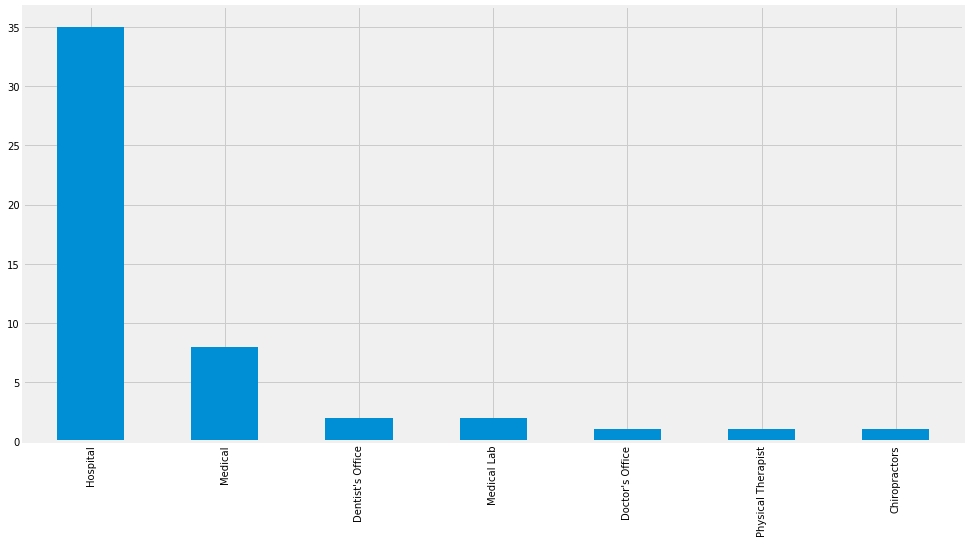

In [8]:
df['Category'].value_counts().plot(
    kind='bar',
    figsize=(15, 8)
)

As we know `Hospital` is leading with 35 and the rest follows.

Let's drop `Address` column as we do not require and most of them are `NaN` values.

In [9]:
df.drop(columns=['Address'], axis=1, inplace=True)
df.head()

,Name,Latitude,Longitude,City,State,Category
0,Sagar Hospital,12.928226,77.599922,Bangalore,Karnātaka,Hospital
1,Fortis International Care,12.894674,77.599067,Bangalore,Karnātaka,Hospital
2,Manipal Hospital,12.959238,77.649208,Bangalore,Karnātaka,Hospital
3,Columbia Asia Hospital,13.050844,77.593750,Bangalore,Karnātaka,Hospital
4,Apollo Hospital,12.896250,77.598653,Bangalore,Karnātaka,Hospital


Let's rename the `State` as `Karnataka` for our convenience.

In [10]:
df['State'] = 'Karnataka'
df.head()

,Name,Latitude,Longitude,City,State,Category
0,Sagar Hospital,12.928226,77.599922,Bangalore,Karnataka,Hospital
1,Fortis International Care,12.894674,77.599067,Bangalore,Karnataka,Hospital
2,Manipal Hospital,12.959238,77.649208,Bangalore,Karnataka,Hospital
3,Columbia Asia Hospital,13.050844,77.593750,Bangalore,Karnataka,Hospital
4,Apollo Hospital,12.896250,77.598653,Bangalore,Karnataka,Hospital


We require the following dataset in order to get dummies for further processing of One-hot-encoding.

In [11]:
temp_df = df[['Category', 'Latitude', 'Longitude']]
temp_df.head()

,Category,Latitude,Longitude
0,Hospital,12.928226,77.599922
1,Hospital,12.894674,77.599067
2,Hospital,12.959238,77.649208
3,Hospital,13.050844,77.593750
4,Hospital,12.896250,77.598653


### Converting the data into One-Hot-Encoding

In [12]:
temp_df = pd.get_dummies(temp_df)
temp_df.head()

,Latitude,Longitude,Category_Chiropractors,Category_Dentist's Office,Category_Doctor's Office,Category_Hospital,Category_Medical,Category_Medical Lab,Category_Physical Therapist
0,12.928226,77.599922,0,0,0,1,0,0,0
1,12.894674,77.599067,0,0,0,1,0,0,0
2,12.959238,77.649208,0,0,0,1,0,0,0
3,13.050844,77.593750,0,0,0,1,0,0,0
4,12.896250,77.598653,0,0,0,1,0,0,0


In [13]:
clf_km = KMeans(n_clusters=5).fit(temp_df)
unique_clusters = {i: np.where(clf_km.labels_ == i)[0] for i in range(clf_km.n_clusters)}
unique_clusters

{0: array([10, 16, 17, 26, 32, 36, 39, 44]),
 1: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 14, 15, 19, 20, 21, 22, 23,
        24, 25, 27, 28, 29, 30, 33, 34, 35, 38, 40, 41, 42, 43, 45, 46, 47,
        49]),
 2: array([13, 18]),
 3: array([31, 37]),
 4: array([11, 12, 48])}

In [14]:
def get_info_index():
    h_vals = df.values
    zones = {}
    for i, j in unique_clusters.items():
        h_z = []
        for h in list(j):
            h_ll = (h_vals[h][0], h_vals[h][1], h_vals[h][2], h_vals[h][5])
            h_z.append(h_ll)
        zones[i] = h_z
    return zones

The above function helps to get the data values for the seperated clusters based on the index values. We retrieve the seperated data and visualize it on `Folium` map showing the hospital name and the category of it.

In [15]:
hospital_zones = get_info_index()
hospital_zones

{0: [('Jindal naturecure institute',
   13.052367977100282,
   77.48331328506973,
   'Medical'),
  ('Care.fit', 13.024602, 77.63698, 'Medical'),
  ('Posture Clinic', 12.909196, 77.640271, 'Medical'),
  ('Ortho Cure Clinic', 13.018993, 77.592536, 'Medical'),
  ('Lucid Medical Diagnostics',
   12.93080353380445,
   77.57959752723141,
   'Medical'),
  ('Navkar Medicals', 12.92963148158496, 77.57172294344674, 'Medical'),
  ('Telerad Rx Dx', 12.976767539978027, 77.71036529541016, 'Medical'),
  ('Sri Sri Ayurveda Hospital',
   12.822264693544481,
   77.5215019147042,
   'Medical')],
 1: [('Sagar Hospital', 12.928225576232041, 77.59992227595576, 'Hospital'),
  ('Fortis International Care',
   12.894674408021086,
   77.59906726125102,
   'Hospital'),
  ('Manipal Hospital', 12.959238002772027, 77.64920827561428, 'Hospital'),
  ('Columbia Asia Hospital', 13.05084408247966, 77.5937501415846, 'Hospital'),
  ('Apollo Hospital', 12.896249721282821, 77.59865309218557, 'Hospital'),
  ('Sakra World Hos

We will set different colors for differ catergories and by running through a loop we will plot the respective coordinates.

In [16]:
colors = ['#135bc3', '#7e06a8', '#b80745', '#34af02', '#f7e105']

hospital_clusters = folium.Map(location=[LAT, LON], zoom_start=11)

for cate in range(len(hospital_zones)):
    for details in hospital_zones[cate]:
        lat = details[1]
        lon = details[2]
        label = details[0] + ', ' + details[3]
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=colors[cate],
            fill=True,
            fill_color=colors[cate],
            fill_opacity=0.7
        ).add_to(hospital_clusters)

hospital_clusters

The above `folium` visualization shows the hospitals that are clustered according to the `Category`. As we see, there are majorly `Hospitals` that are speclised for all types of diseases but not specifically to a particular type. As of now I have only considered one locality but we can take different localities. We just need to the `LAT` and `LON` coordinates and then we can obtain the analysis and visulization pertaining to that locality.

There are few objectives which I could not achieve due to some data insuffiency. But we can either way enhance this project by having some more inputs and certain criterion that need to be studied and certain research methodologies need to consider in order to take it to the next step.

### Overall it was a fun project doing coding and analysis of something which I  was unaware of. `HAPPY CODING` `HAPPY LEARNING`.

## Credits

* Google Images $\rightarrow$ http://goaspro.com/wp-content/uploads/2019/05/screenshot-eu-gb.dataplatform.cloud_.ibm_.com-2019.05.13-09-41-23.png